### Обнаружение DNS туннелей в трафике

Предлагаемый подход: на основе n-грамм для анализа имен dns запросов

**Идея:** распределение частот встречаемости n-грамм в именах dns запросов (сейчас для простоты, но далее можно использовать энтропию и взаимную информацию) существенно отличается от "нормального" распределения частот. В качестве нормального в первом приближении можно использовать статистические соображения из естественного языка.

Другие подходы:
* статистические признаки запросов и ответов (в том числе размеры пакетов, время между сессиями)
* может на географическую локацию самих серверов можно смотреть

#### получим имена dns запросов

In [1]:
file_name ="D:/Downloads/CTU-13-Dataset/9/botnet-capture-20110817-bot.pcap"
dns_temp_data = !tshark -r $file_name -T fields -e dns.qry.name -Y "dns.flags.response eq 0"

In [2]:
df = pd.DataFrame(dns_temp_data,columns=['dns_query'])
print(df.shape,df.drop_duplicates('dns_query').shape)
df.head()

(221031, 1) (54634, 1)


,dns_query
0,nocomcom.com
1,nocomcom.com
2,w.nucleardiscover.com
3,w.nucleardiscover.com
4,mewgost.com


#### Построим гистограмму всего pcap'а

* признак - 1 символ английского алфавита

In [3]:
from sklearn.feature_extraction.text import CountVectorizer
from string import ascii_lowercase
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


In [4]:
vocabulary = ascii_lowercase
count_vec = CountVectorizer(lowercase=False,ngram_range=(1,1),analyzer='char',vocabulary=vocabulary)
X_char = count_vec.fit_transform(df.dns_query)
print(X_char.shape)

df_tdm = pd.DataFrame(data=X_char.toarray(),columns=count_vec.get_feature_names())
df_tdm.shape

(221031, 26)


(221031, 26)

#### Нормализуем

In [5]:
df_tdm = df_tdm/len(vocabulary)
df_tdm.head()

,a,b,c,d,e,f,g,h,i,j,...,q,r,s,t,u,v,w,x,y,z
0,0.000000,0.0,0.115385,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
1,0.000000,0.0,0.115385,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
2,0.038462,0.0,0.115385,0.038462,0.076923,0.0,0.000000,0.0,0.038462,0.0,...,0.0,0.076923,0.038462,0.000000,0.038462,0.038462,0.038462,0.0,0.0,0.0
3,0.038462,0.0,0.115385,0.038462,0.076923,0.0,0.000000,0.0,0.038462,0.0,...,0.0,0.076923,0.038462,0.000000,0.038462,0.038462,0.038462,0.0,0.0,0.0
4,0.000000,0.0,0.038462,0.000000,0.038462,0.0,0.038462,0.0,0.000000,0.0,...,0.0,0.000000,0.038462,0.038462,0.000000,0.000000,0.038462,0.0,0.0,0.0


#### Согласно [авторам](http://norvig.com/mayzner.html) возьмем топовые буквы английского языка и построим распределение на наших данных.

#### Конечно, в дальнейшем неплохо бы иметь траффик с "нормальным" поведением, чтобы убедиться, что в нем будут такие же закономерности, что и на этих искусственных примерах

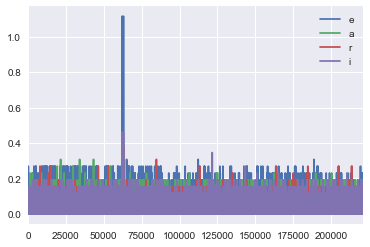

In [6]:
df_tdm[['e','a','r','i']].plot()

#### Теперь возьмем низкочастотные буквы английского языка и тоже построим распределение на наших даннных

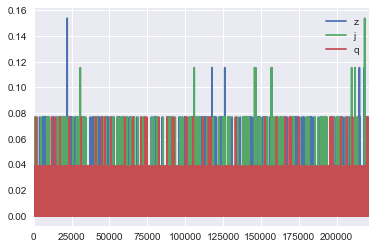

In [7]:
df_tdm[['z','j','q']].plot()

#### Распределения очень похожи, хотя не должны быть, значит можно пробовать использовать эти признаки для классификации

### Далее:
* нужно больше данных (с туннелями и без)
* достроить модель и попробовать биграммы, учитывать числа и т.д
* если не получится, попробовать другой подход